In [1]:
import os

for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive/Submission.csv
archive/fer2013/fer2013/fer2013.csv
archive/fer2013/fer2013/fer2013.bib
archive/fer2013/fer2013/README


In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

from livelossplot.tf_keras import PlotLossesCallback

import tensorflow.keras.utils as np_utils

from tensorflow.keras.applications import VGG19


# Analisis de datos

In [12]:
df = pd.read_csv('archive/fer2013/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [15]:
print(f'Hay {df.shape[0]} imagenes en total y {df.shape[1]} columnas')
print(f'Numero de emociones: {df.emotion.nunique()}')
print(f'Numero de imagenes por emocion: {df.emotion.value_counts()}')

Hay 35887 imagenes en total y 3 columnas
Numero de emociones: 7
Numero de imagenes por emocion: emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


In [4]:
emotion_label_to_text = {
    0:'anger', 1:'disgust', 2:'fear', 
    3:'happiness', 4:'sadness', 5:'surprise', 
    6:'neutral'
}

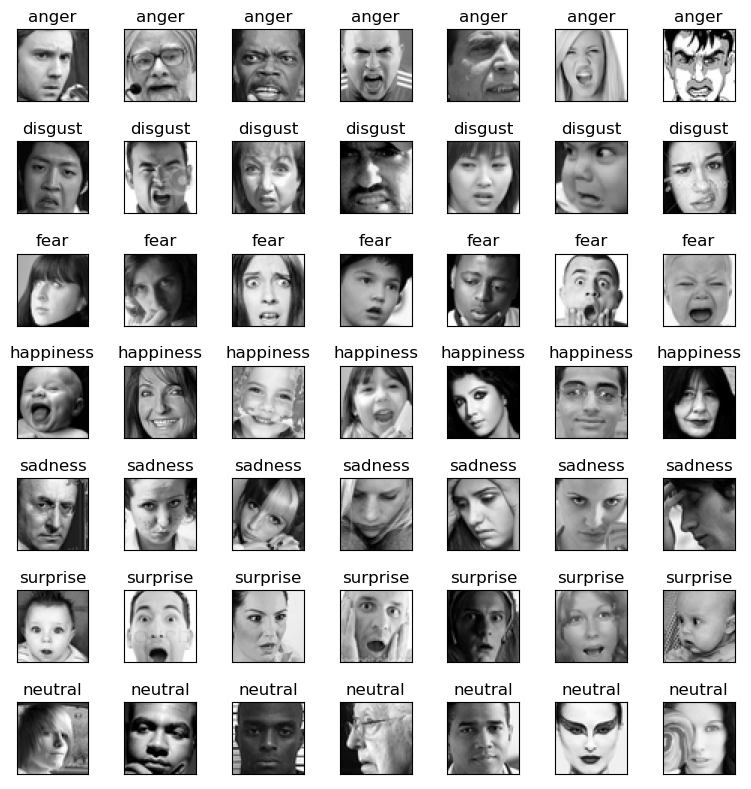

In [20]:
fig = plt.figure(1, (8, 8))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7,7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

# Convertir Pixel -> Image y GRAY -> RGB

- Separar los pixeles leidos en la columna *Pixels*
- Convertir a una imagen 48x48
- Cambiar de tipo a Float32

In [22]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)
img_array.shape

(35887, 48, 48)

- Convertir la imagen de escala de grises a RGB, sirve para el Transfer Learning

In [23]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
img_features.shape

(35887, 48, 48, 3)

# Codificacion One-Hot

- ***le.fit_transform(df.emotion):*** La emocion de cada imagen en el dataset las colocamos en un array
- ***np_utils.to_categorical(img_labels):*** Colocamos la emocion de cada imagen del dataset con la codificacion One-Hot, por ejemplo [1. 0. 0. 0. 0. 0. 0.] significa que esa imagen es enojada, [0. 0. 1. 0. 0. 0. 0.] significa que esa imagen es miedo (fear).

In [25]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [26]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

# Configuracion del modelo

In [ ]:
CONFIGURATION = {
    "IM_SIZE": 48,
    "FINAL_CONV_LAYER": -2,
    "NUM_CLASSES": 7,
    "LEARNING_RATE": 0.0001,
    "BATCH_SIZE": 32, 
    "N_EPOCHS": 25,
}

# Preprocesamiento

Repartir el dataset para entrenamiento y validación

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
    img_features, 
    img_labels, 
    shuffle = True, 
    stratify = img_labels, 
    test_size = 0.1, 
    random_state = 42
)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [29]:
del df
del img_features
del img_labels

Normalizacion

In [30]:
X_train = X_train / 255.
X_valid = X_valid / 255.

Data Augmentation - No se usa flow_from_directory porque la data ya esta como X_train y Y_train, y se usa fit

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,)

train_datagen.fit(X_train)

# Transfer Learning - VGG19

In [ ]:
vgg = VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = (
        CONFIGURATION['IM_SIZE'],
        CONFIGURATION['IM_SIZE'], 
        3
    ))

vgg.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 48, 48, 3) │          0 │ input_layer_1[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 24, 24,    │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 24, 24,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 24, 24,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 24, 24,    │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 24, 24,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 24, 24,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 24, 24,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 25, 25,    │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 12, 12,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 12, 12,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [37]:
def build_model(bottom_model):
    model = bottom_model.layers[CONFIGURATION["FINAL_CONV_LAYER"]].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(CONFIGURATION["NUM_CLASSES"],
                  activation = 'softmax', 
                  name = 'out_layer')(model)
    
    return model

In [38]:
head = build_model(vgg)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 48, 48, 3) │          0 │ input_layer_1[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 24, 24,    │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 24, 24,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 24, 24,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 24, 24,    │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 24, 24,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 24, 24,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 24, 24,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 25, 25,    │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 12, 12,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 12, 12,    │        256 │ expanded_conv_1_

 Total params: 2,999,239 (11.44 MB)

 Trainable params: 2,976,759 (11.36 MB)

 Non-trainable params: 22,480 (87.81 KB)

None


# Callbacks para entrenamiento

In [48]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.00005, 
    patience = 11,
    verbose = 1, 
    restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    factor = 0.3, 
    patience = 7,
    min_lr = 1e-7,
    verbose = 1,)

callbacks = [PlotLossesCallback(), early_stopping,lr_scheduler,]

# Optimizer, Loss y Metrics

In [49]:
optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE'],
               beta_1 = 0.9, beta_2 = 0.999)

metrics = [
    CategoricalAccuracy(name='accuracy'),
    TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = metrics)

# Entrenamiento

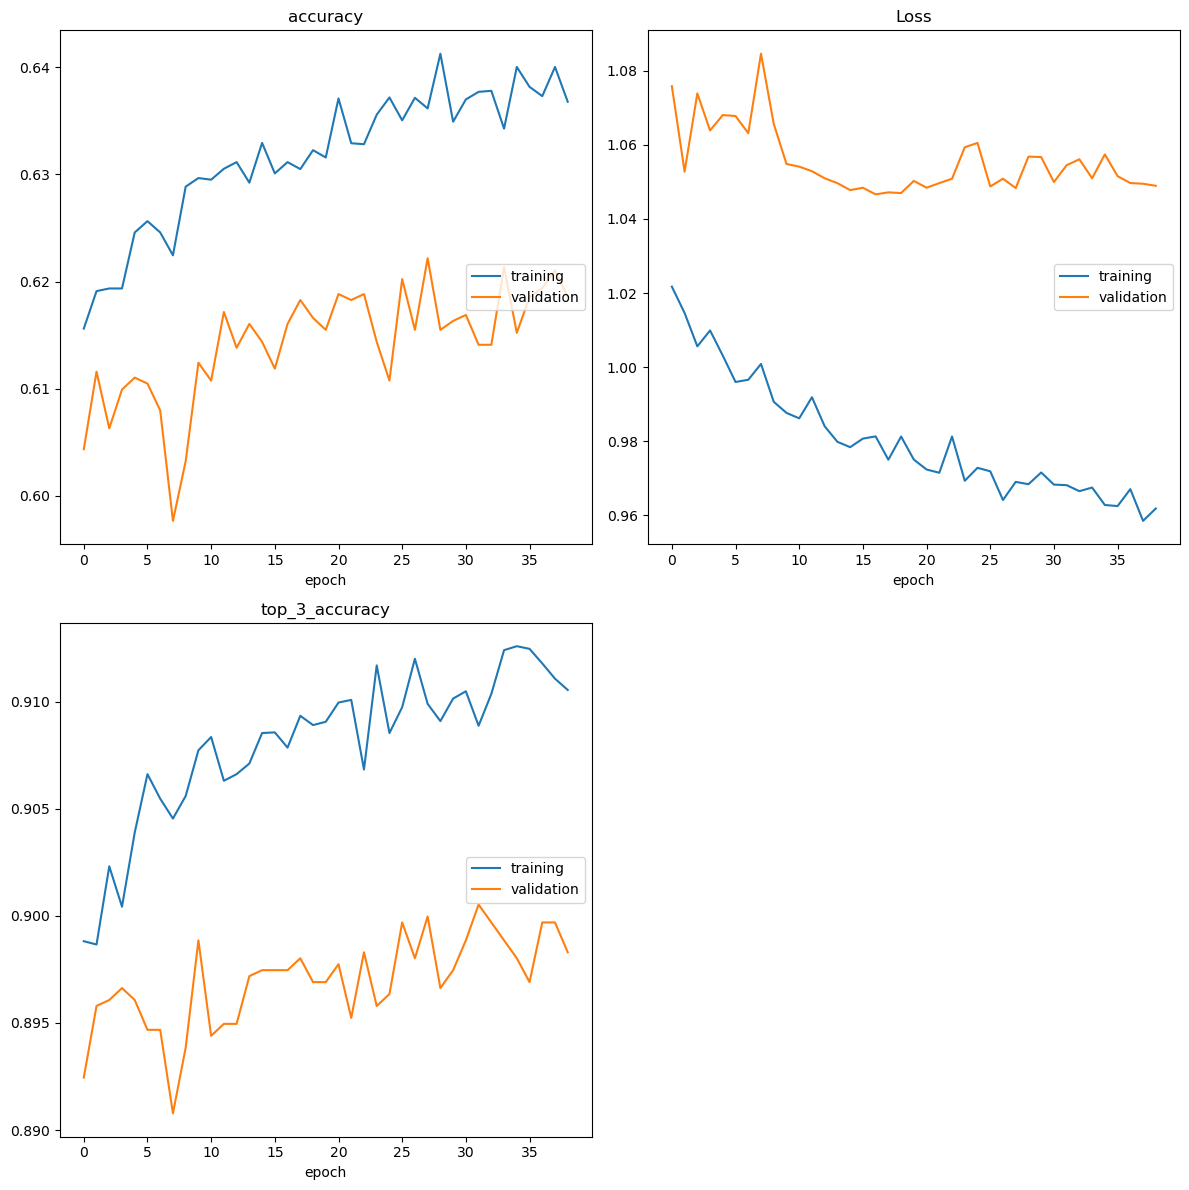

accuracy
	training         	 (min:    0.616, max:    0.641, cur:    0.637)
	validation       	 (min:    0.598, max:    0.622, cur:    0.619)
Loss
	training         	 (min:    0.959, max:    1.022, cur:    0.962)
	validation       	 (min:    1.047, max:    1.085, cur:    1.049)
top_3_accuracy
	training         	 (min:    0.899, max:    0.913, cur:    0.911)
	validation       	 (min:    0.891, max:    0.901, cur:    0.898)
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6348 - loss: 0.9663 - top_3_accuracy: 0.9094 - val_accuracy: 0.6186 - val_loss: 1.0489 - val_top_3_accuracy: 0.8983 - learning_rate: 9.0000e-07
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 28.


In [50]:
steps_per_epoch = math.ceil(len(X_train) / CONFIGURATION['BATCH_SIZE'])

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size = CONFIGURATION['BATCH_SIZE']),
    validation_data = (X_valid, y_valid),
    steps_per_epoch = steps_per_epoch,
    epochs = CONFIGURATION['N_EPOCHS'],
    callbacks = callbacks)

In [55]:
model_yaml = model.to_json()
with open("model_mbn.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_mbn.h5")

# Resultados

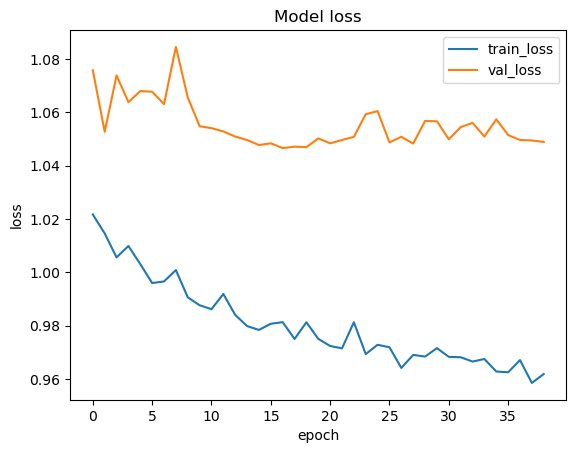

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

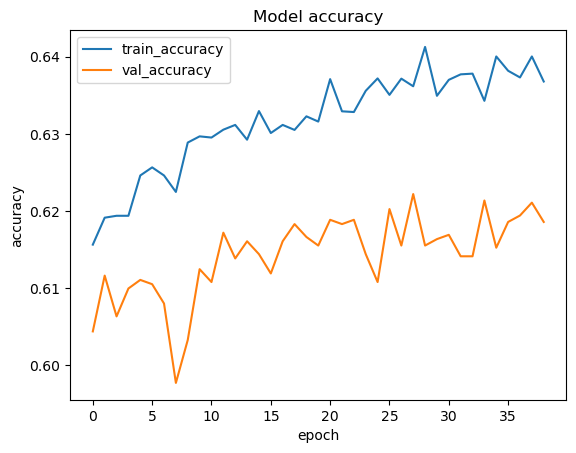

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [53]:
# val_loss, val_accuracy, _ = model.evaluate(X_valid, verbose = 0)
# print(f"Validation loss: {val_loss:.4f}")
# print(f"Validation accuracy: {val_accuracy:.4f}")

# Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
total wrong validation predictions: 1356


              precision    recall  f1-score   support

           0       0.51      0.58      0.54       495
           1       0.64      0.49      0.56        55
           2       0.55      0.41      0.47       512
           3       0.80      0.83      0.82       899
           4       0.52      0.46      0.49       608
           5       0.73      0.74      0.74       400
           6       0.53      0.63      0.57       620

    accuracy                           0.62      3589
   macro avg       0.61      0.59      0.60      3589
weighted avg       0.62      0.62      0.62      3589



<Figure size 640x480 with 0 Axes>

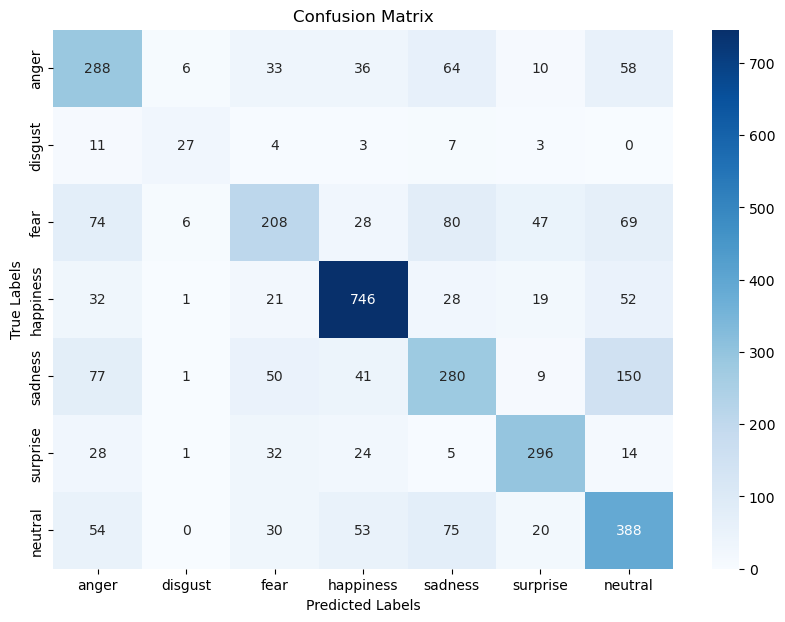

In [ ]:
y_pred = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != y_pred)}\n\n')
print(classification_report(y_true, y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(emotion_label_to_text.values()), 
            yticklabels=list(emotion_label_to_text.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()